In [ ]:
import torch
from torch import optim, nn
from torchvision import models, transforms
model = models.vgg16(pretrained=True)

In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, model):
    super(FeatureExtractor, self).__init__()
		# Extract VGG-16 Feature Layers
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
		# Extract VGG-16 Average Pooling Layer
    self.pooling = model.avgpool
		# Convert the image into one-dimensional vector
    self.flatten = nn.Flatten()
		# Extract the first part of fully-connected layer from VGG16
    self.fc = model.classifier[0]
  
  def forward(self, x):
		# It will take the input 'x' until it returns the feature vector called 'out'
    out = self.features(x)
    out = self.pooling(out)
    out = self.flatten(out)
    out = self.fc(out) 
    return out 

# Initialize the model
model = models.vgg16(pretrained=True)
new_model = FeatureExtractor(model)

# Change the device to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
new_model = new_model.to(device)

In [ ]:
from tqdm import tqdm
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow

# Transform the image, so it becomes readable with the model
transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.CenterCrop(512),
  transforms.Resize(448),
  transforms.ToTensor()                              
])

# Will contain the feature
features = []
path = '/content/data'
images = os.listdir(path)
print("Total images:", len(images))
# for image in images:
#   print(image)
# Iterate each image
for i in images:
    # Set the image path
    # print("i:", i)
    # print('path:', path)
    imagePath = os.path.join(path + '/', str(i))
    # print(imagePath)
    # Read the file
    img = cv2.imread(imagePath)
    # cv2_imshow(img)
    # Transform the image
    img = transform(img)
    # Reshape the image. PyTorch model reads 4-dimensional tensor
    # [batch_size, channels, width, height]
    img = img.reshape(1, 3, 448, 448)
    img = img.to(device)
    # We only extract features, so we don't need gradient
    with torch.no_grad():
      # Extract the feature from the image
      feature = new_model(img)
    # Convert to NumPy Array, Reshape it, and save it to features variable
    features.append(feature.cpu().detach().numpy().reshape(-1))

# Convert to NumPy Array
features = np.array(features)
print(features.shape)
print(features[0])

(37,)
4


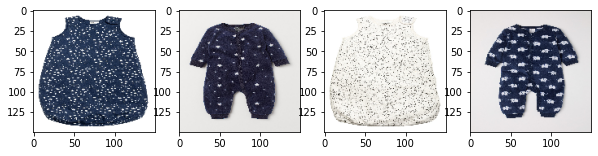

In [34]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Initialize the model
model = KMeans(n_clusters=6, random_state=42)

# Fit the data into the model
model.fit(features)

# Extract the labels
labels = model.labels_

labels = np.array(labels)
print(labels.shape)
fig = plt.figure(figsize=(10,10))
numImages = len(np.where(labels == 1)[0])
# numImages = labels.shape[0] - np.count_nonzero(labels)
print(numImages)
num = 0
for i in range(labels.shape[0]):
  if(labels[i] == 1):
    imagePath = os.path.join(path + '/', str(images[i]))
    img = image.load_img(imagePath, target_size=(150,150))
    plt.subplot(1, numImages, num+1)
    plt.imshow(img)
    num += 1

# print(labels) # [4 3 3 ... 0 0 0]